In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
import pickle
import scipy.io as sio
import pysindy as ps

import matplotlib.pyplot as plt

from tqdm import tqdm
from nn_FNO import FNO1d
from nn_MLP import *
from nn_step_methods import *
from ensemble_FP import ensemble_FP
from Obs_func_generator import EnsKFstep_module
from nn_FP_net import *
import hdf5storage

2.1.1+cu121
2.1.1+cu121
2.1.1+cu121
2.1.1+cu121


In [2]:
def load_output_data(num_chunks, file_path, M,):

    output_data = np.zeros([int(M),16])
    # output_data_RMSE = np.zeros([int(M)+1])
    # output_data_FFT_X = np.zeros([int(M)+1,512])

    start_ind = 0
    for k in range(0, num_chunks):
        out = np.load(file_path+str(k)+'.npz', allow_pickle=True)#[10000:,:,:,:]
        t_range = out['arr_0'].shape[1]
        # print(out['arr_0'].shape)
        output_data[start_ind:start_ind+t_range] = out['arr_0'].T
        # output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        # output_data_FFT_X[start_ind:start_ind+t_range,:,:512] = out.item()['prediction'][:,:,:512]
        start_ind += t_range
        # print(start_ind)
        if k % 10 == 0: print(k)

    return torch.from_numpy(output_data).float()#, torch.from_numpy(output_data_RMSE).float(), torch.from_numpy(output_data_FFT_X).float()

In [3]:
num_chunks = 100
M = 10000000
file_path = "/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KdV_data_spectral_alpha_5_delta_1_nu_0.001_long/KdV_data_spectral_alpha_5_delta_1_nu_0.001_long_chunk_"
output_data = load_output_data(num_chunks, file_path, M)

0
10
20
30
40
50
60
70
80
90


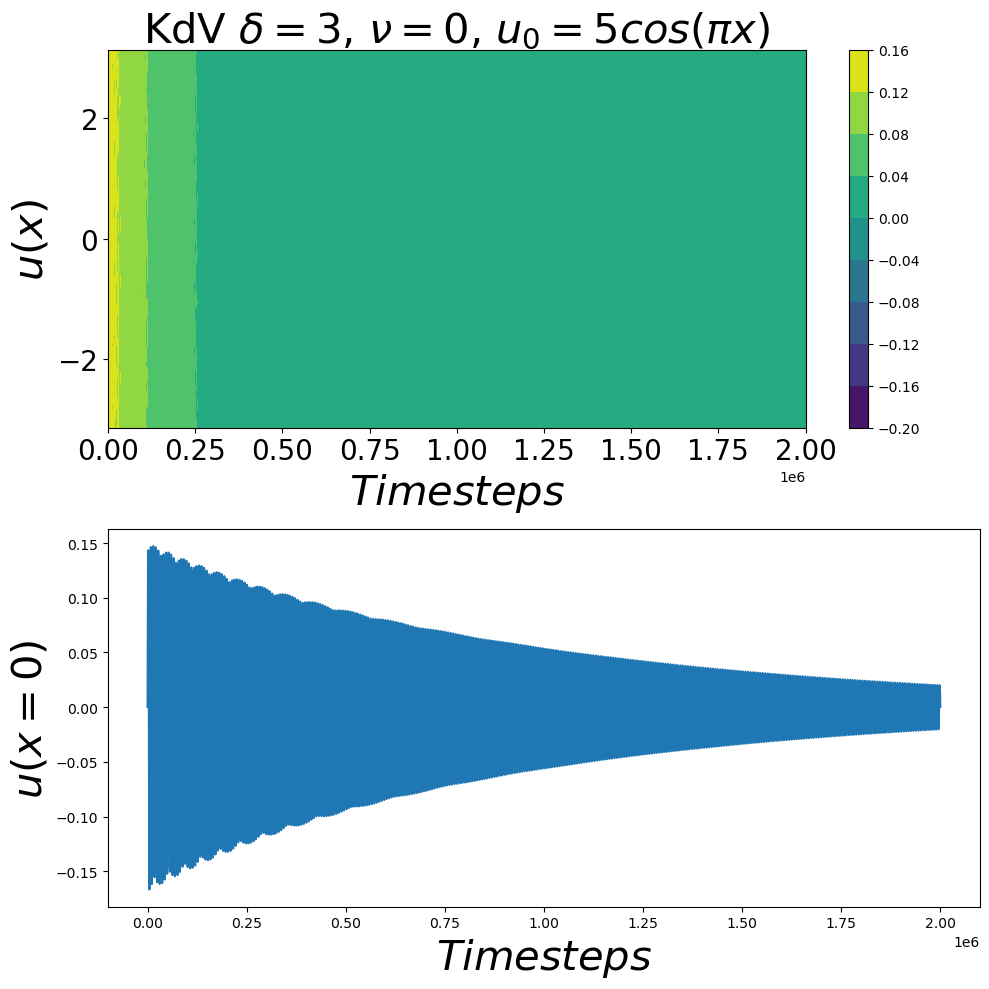

In [21]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
param_name = r'KdV $\delta=3$, $\nu=0$, $u_0=5cos(\pi x)$'

im = axs[0].contourf(output_data[::1000].T, extent=[0,2000000,-3.14,3.14])
axs[0].set_title(param_name, fontsize=30)
axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$u(x)$', fontsize=30)
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)
plt.colorbar(im, ax=axs[0])

axs[1].plot(range(0,int(2000000)), output_data[:2000000,8])
# axs[1].plot(range(0,int(M)), output_data[:,8])

axs[1].set_xlabel(r'$Timesteps$', fontsize=30)
axs[1].set_ylabel(r'$u(x=0)$', fontsize=30)
# axs[1].xaxis.set_tick_params(labelsize=20)
# axs[1].yaxis.set_tick_params(labelsize=20)

fig.tight_layout()
# fig.savefig('KdV_alpha_d_1_nu_0.001.png', dpi=fig.dpi, bbox_inches='tight')

In [5]:
num_chunks = 100
M = 2000000
file_path = "/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KdV_data_spectral_alpha_5_delta_1_nu_0_long/KdV_data_spectral_alpha_5_delta_1_nu_0_long_chunk_"
output_data_2 = load_output_data(num_chunks, file_path, M)

0
10
20
30
40
50
60
70
80
90


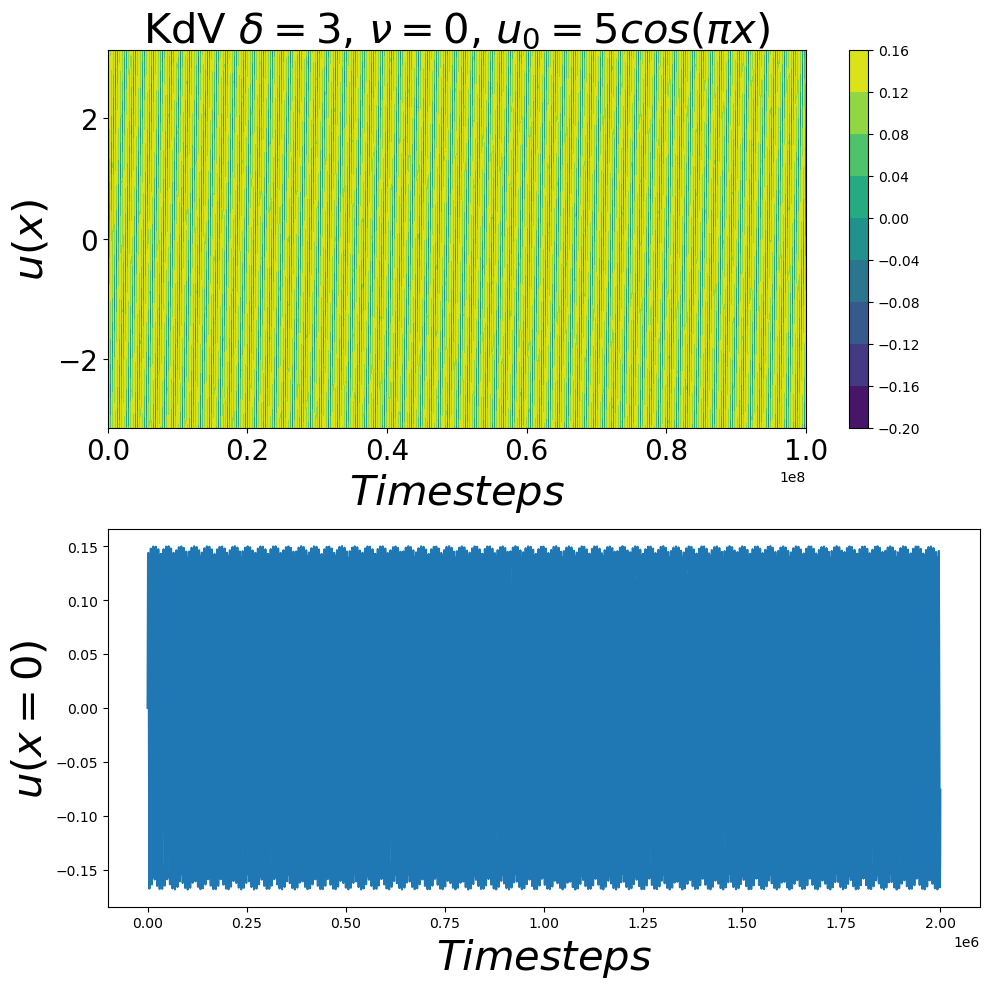

In [33]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
param_name = r'KdV $\delta=3$, $\nu=0$, $u_0=5cos(\pi x)$'

im = axs[0].contourf(output_data_2[::1000].T, extent=[0,100000000,-3.14,3.14])
axs[0].set_title(param_name, fontsize=30)
axs[0].set_xlabel(r'$Timesteps$', fontsize=30)
axs[0].set_ylabel(r'$u(x)$', fontsize=30)
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)
plt.colorbar(im, ax=axs[0])

# axs[1].plot(range(0,int(2000000/100)), output_data[:2000000:100,8])
axs[1].plot(range(0,int(M)), output_data_2[:,8])

axs[1].set_xlabel(r'$Timesteps$', fontsize=30)
axs[1].set_ylabel(r'$u(x=0)$', fontsize=30)
# axs[1].xaxis.set_tick_params(labelsize=20)
# axs[1].yaxis.set_tick_params(labelsize=20)

fig.tight_layout()
# fig.savefig('KdV_alpha_5_d_1_nu_0.png', dpi=fig.dpi, bbox_inches='tight')

In [12]:
L = 2*np.pi
# L = 20
m = 16
x = np.arange(-m/2,m/2)*(L/m)

dx = np.abs(x[1] - x[0])
dt = 1e-3
# u = np.array(output_data[:2000000].T)
# u = np.array(output_data_2[:2000000].T)

u = np.array(output_data[:200000].T - output_data_2[:200000].T)

u = u.reshape(x.size,u.shape[1],1)

library_functions = [lambda x: x]
f_names = [lambda x: f'{x}']

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=f_names,
                        derivative_order=3, spatial_grid=x,
                        include_bias=False,
                        include_interaction=True,
                        is_uniform=True, periodic=True)


optimizer = ps.STLSQ(threshold=.75, alpha=1e-2, normalize_columns=False)
# optimizer = ps.STLSQ(threshold=2.25, alpha=1e-5, normalize_columns=False)
# optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2, thresholder='l0', normalize_columns=True)
# optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, t_default=dt)
print('Starting fit')
model.fit(u, t=dt)
print('Fit ended')
model.print()


Starting fit
Fit ended
(x0)' = 1.028 x0_1


X min and max -3.141592653589793 2.945243112740431 , dx  0.1963495408493623
KdV_data_spectral_delta_1_nu_0_long_v2
u min and max -0.15 0.15
0
7.63943726841097e-06 0.15000000000000002 -0.15000000000000002
100000
1.2934560405256978e-05 0.1268249280931604 -0.25396949966605487
200000
1.2217166362984297e-05 0.11732872869191267 -0.239883500585224
300000
1.1110280070662456e-05 0.12000234617766473 -0.21814983905823937
400000
1.3091721941351837e-05 0.11752266534479425 -0.2570553592111955
500000
8.206003593867527e-06 0.14960845075984602 -0.16112450378641058
600000
1.2330056010749258e-05 0.1338925701240632 -0.24210008363575367
700000
1.2669316884888555e-05 0.1132008316245223 -0.24876145532229405
800000
1.000765342337224e-05 0.12151465094218046 -0.19649981546586878
900000
1.3442635620632977e-05 0.10529010488624442 -0.2639455331916567
Output finished


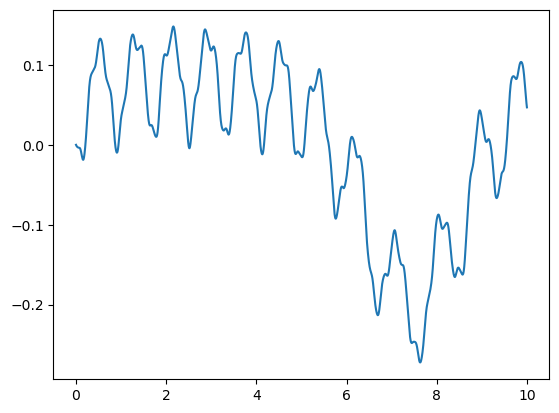

In [18]:
def RK4Step(u,kx):
    k1 = rhs(u,kx)
    k2 = rhs(u+0.5*dt*k1,kx)
    k3 = rhs(u+0.5*dt*k2,kx)
    k4 = rhs(u+dt*k3,kx)
    return u + (k1+2*k2+2*k3+k4)*(dt/6.)

#----- Constructing the grid -----
L = 2*np.pi
# L = 20
m = 32
x = np.arange(-m/2,m/2)*(L/m)
print('X min and max',x.min(), x.max(),', dx ', x[1]-x[0])
kx = np.fft.fftfreq(m)*m*2*np.pi/L

#----- Parameters -----
alpha = 50
# delta  = 0.022*150
# delta  = 0.5
# delta3 = delta**3
delta3 = 1
nu = 0
# nu = 0.1

#----- Define RHS -----
def rhs(uhat, kx):
    u = np.fft.ifft(uhat)
    return alpha*np.fft.fft(u*(np.fft.ifft(1j*kx*uhat))) - delta3*(-1j*kx**3*uhat) -nu*kx**2*uhat

file_name = 'KdV_data_spectral_delta_'+str(delta3)+'_nu_'+str(nu)+'_long_v2'
file_path ='/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/'+file_name+'/'
print(file_name)

# prev_chunk = np.load('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KdV_data_spectral_delta_1.1_nu_0.1_long_v2/KdV_data_spectral_delta_1.1_nu_0.1_long_v2_chunk_99.npz')
# last_dt = prev_chunk['arr_0'][:,-1]

#------ Initial conditions -----
u0      = (0.15)*np.sin(x)#*np.exp(-0.2*x**2)

# u0 = last_dt

uhat0   = np.fft.fft(u0)
print('u min and max',u0.min(), u0.max())

#------ Solving for ODE -----
t0 = 0
# dt = 1.73/((m/2)**3)
dt = 1e-5

# nt = 10000000 #for roughly one period, when d3 = 1
nt = 1000000

usim = np.zeros([m,nt])
# print(usim.shape)

for i in range (0, nt):
  if i == 0:
    upred = uhat0
    usim [:,i] = np.real(np.fft.ifft(upred))
  else:
    upred = RK4Step(upred,kx)
    usim [:,i] = np.real(np.fft.ifft(upred))
  if i%100000==0:
    print(i)
    print((np.abs(usim[:,i]).max()*dt)/np.abs((x[1]-x[0])), np.max(usim[:,i]), np.min(usim[:,i]))
  if np.isnan(upred).any():
     print('Nan found at timestep '+str(i))
     break
print('Output finished')

x_val = int(6.24/38)
plt.plot(np.arange(0, nt)*dt, usim[x_val])
# plt.plot(np.arange(0, nt)*dt, usim_pred[x_val],':')
# usim_pred = usim

In [2]:

#----- Constructing the grid -----
L = 2*np.pi
# L = 20
m = 32
x = np.arange(-m/2,m/2)*(L/m)
dx = x[1] - x[0]
dt = 1e-5
kx = np.fft.fftfreq(m)*m*2*np.pi/L

#----- Parameters -----
alpha = 5
delta3 = 1
nu = 0.25

def RK4Step_w_dt(u,kx):
    k1 = rhs(u,kx)
    k2 = rhs(u+0.5*dt*k1,kx)
    k3 = rhs(u+0.5*dt*k2,kx)
    k4 = rhs(u+dt*k3,kx)
    return u + (k1+2*k2+2*k3+k4)*(dt/6.), k1


#----- Define RHS -----
def rhs(uhat, kx):
    u = np.fft.ifft(uhat)
    return alpha*np.fft.fft(u*(np.fft.ifft(1j*kx*uhat))) - delta3*(-1j*kx**3*uhat) -nu*kx**2*uhat

#------ Initial conditions -----
u0      = (0.15)*np.sin(x)#*np.exp(-0.2*x**2)
# u0      = np.sin(x)#*np.exp(-0.2*x**2)

# u0 = last_dt

uhat0   = np.fft.fft(u0)
print('u min and max',u0.min(), u0.max())

#------ Solving for ODE -----
t0 = 0
# dt = 1.73/((m/2)**3)
dt = 1e-5

# trange = 10000000 #for roughly one period, when d3 = 1
trange = 1000000

usim = np.zeros([m,trange])
usim_dt = np.zeros([m,trange])

for i in range (0, trange):
  if i == 0:
    upred = uhat0
    _, upred_dt = RK4Step_w_dt(upred, kx)
    usim [:,i] = np.real(np.fft.ifft(upred))
    usim_dt [:,i] = np.real(np.fft.ifft(upred_dt))

  else:
    upred, upred_dt = RK4Step_w_dt(upred,kx)
    usim [:,i] = np.real(np.fft.ifft(upred))
    usim_dt [:,i] = np.real(np.fft.ifft(upred_dt))

  if i%100000==0:
    print(i)
    print((np.abs(usim[:,i]).max()*dt)/np.abs((x[1]-x[0])), np.max(usim[:,i]), np.min(usim[:,i]))
  if np.isnan(upred).any():
     print('Nan found at timestep '+str(i))
     break
print('Output finished')

u min and max -0.15 0.15
0
7.63943726841097e-06 0.15000000000000002 -0.15000000000000002
100000
6.048467643548433e-06 0.11406033925648038 -0.11876138446529591
200000
4.7283631128200096e-06 0.08818151540728962 -0.09284119261712702
300000
3.674680292191273e-06 0.06867385001552909 -0.07215217881399569
400000
2.8495040788389084e-06 0.05362083925302372 -0.055949881752840464
500000
2.2084913173187904e-06 0.04188367701660099 -0.043363625612534776
600000
1.7119169244170835e-06 0.03269817990054511 -0.03361341020815468
700000
1.3274078585073932e-06 0.025505614803596813 -0.02606359235377619
800000
1.0300566475657198e-06 0.01989555560425 -0.02022511497983625
900000
8.019773770371756e-07 0.015545912303641022 -0.015746788975282533
Output finished


(1000000, 14) (1000000,)
Fit: 6 out of 14 candidate terms.
Fit: regression weights of each term:
uxx : 0.2536440396575622
u^2 : 0.022170762262451616
u uxx : -0.09346949976780085
ux uxx : -0.014923026036596444
uxx^2 : -0.11139786131527722
uxx uxxx : -0.02420720005567652


AttributeError: 'RVR' object has no attribute 'predict_proba'

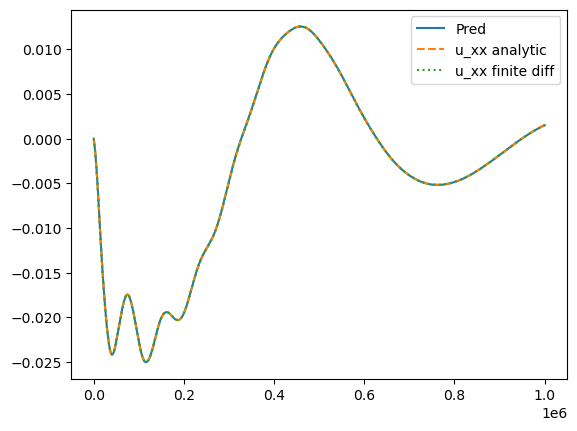

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from rvm import *

L = 2*np.pi
# L = 20
m = 32
x = np.arange(-m/2,m/2)*(L/m)
dx = np.abs(x[1] - x[0])
dt = 1e-5
kx = np.fft.fftfreq(m)*m*2*np.pi/L


#----- Parameters -----
alpha = 5
delta3 = 1
nu = 0.25

def rhs_batch_no_uxx(uhat, kx, alpha, delta3):
    u = np.fft.ifft(uhat, axis=1)
    return alpha*np.fft.fft(u*(np.fft.ifft(1j*kx.reshape(1,-1)*uhat, axis=1)), axis=1) - delta3*(-1j*kx.reshape(1,-1)**3*uhat)

def target_analytic_batch(uhat, kx, nu):
    u = np.fft.ifft(uhat, axis=1)
    return -nu*kx.reshape(1,-1)**2*uhat

# u = np.array(output_data[:trange])
trange = 10000000

u = usim.T
u_dt = usim_dt.T
trange = np.shape(u)[0]

u_fft = np.fft.fft(u, axis=1)
u_dt_hat = rhs_batch_no_uxx(u_fft, kx, alpha, delta3)
u_dt_hat = np.real(np.fft.ifft(u_dt_hat, axis=1))

# u_dt = np.gradient(u, axis=0) / dt
u_diff = np.array((u_dt - u_dt_hat)) #using the analytic equation for ut at each point

# u_diff = u_dt #for testing

uxx_analytic = target_analytic_batch(u_fft, kx, nu)
uxx_analytic = np.real(np.fft.ifft(uxx_analytic, axis=1)) 


ux = np.gradient(u, dx, axis=1) 
uxx = np.gradient(ux, dx, axis=1) 
uxxx = np.gradient(uxx, dx, axis=1) 

# U_full = np.stack([u.reshape(-1), ux.reshape(-1), uxx.reshape(-1), uxxx.reshape(-1)], axis=1)
# y = u_diff.reshape(-1) 

# U_full = np.stack([u[:,3:m-3].reshape(-1), ux[:,3:m-3].reshape(-1), uxx[:,3:m-3].reshape(-1), uxxx[:,3:m-3].reshape(-1)], axis=1)
# y = u_diff[:,3:m-3].reshape(-1) 

U_full = np.stack([u[:,16], ux[:,16], uxx[:,16], uxxx[:,16]], axis=1)
y = u_diff[:,16]

feature_names = ['u','ux','uxx','uxxx']

poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
u_dict= poly.fit_transform(U_full)
print(u_dict.shape, y.shape)
feature_names_out = poly.get_feature_names_out(feature_names)

clf = RVR(threshold_alpha = 1e4, n_iter = 100, verbose = False, standardise=False, bias_used=False, tol=1e-15)
clf.fit(u_dict, y, feature_names_out)

# plt.title('Predictions of nu*u_xx using the RVM algorithm')
# plt.plot(clf.predict(u_dict[16::m]))
# plt.plot(uxx_analytic[:,16],'--')
# plt.plot(y[16::m],':')
# plt.xlabel('Timesteps, dt=1e-5')
# plt.ylabel('u(x=0)')
# plt.plot(clf.predict(u_dict[16::m-6]))
# plt.plot(uxx_analytic[:,19],'--')
# plt.plot(y[16::m-6],':')

plt.plot(clf.predict(u_dict[:]))
plt.plot(uxx_analytic[:,16],'--')
plt.plot(y[:],':')

plt.legend(['Pred', 'u_xx analytic', 'u_xx finite diff'])
print(clf.predict_proba(u_dict))

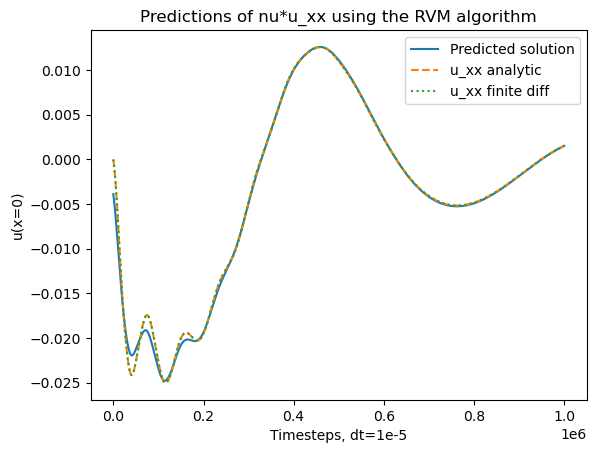

In [94]:

plt.title('Predictions of nu*u_xx using the RVM algorithm')
plt.plot(clf.predict(u_dict[16::m]))
plt.plot(uxx_analytic[:,16],'--')
plt.plot(y[16::m],':')
plt.xlabel('Timesteps, dt=1e-5')
plt.ylabel('u(x=0)')
# plt.plot(clf.predict(u_dict[16::m-6]))
# plt.plot(uxx_analytic[:,19],'--')
# plt.plot(y[16::m-6],':')

# plt.plot(clf.predict(u_dict[:]))
# plt.plot(uxx_analytic[:,16],'--')
# plt.plot(y[:],':')

plt.legend(['Predicted solution', 'u_xx analytic', 'u_xx finite diff'])

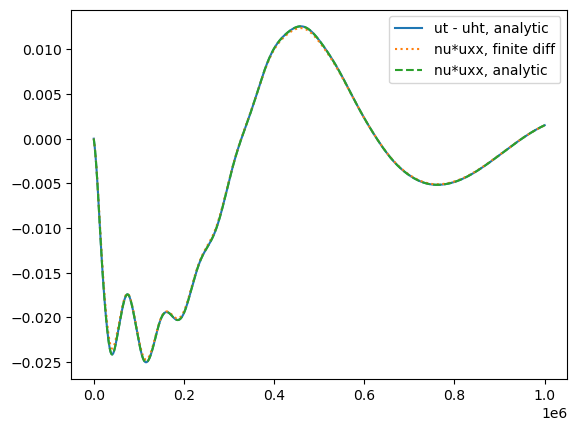

In [82]:
plt.plot(y[:])
plt.plot(nu*uxx[:,16],':')
plt.plot(uxx_analytic.reshape(-1)[16::m],'--')
plt.legend(['ut - uht, analytic','nu*uxx, finite diff','nu*uxx, analytic'])

# plt.plot(uxx[:,8],'--')

# plt.plot(u[:,8],':')

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from rvm import *

L = 2*np.pi
# L = 20
m = 32
x = np.arange(-m/2,m/2)*(L/m)
dx = np.abs(x[1] - x[0])
dt = 1e-5
kx = np.fft.fftfreq(m)*m*2*np.pi/L


#----- Parameters -----
alpha = 5
delta3 = 1
nu = 0.25

def rhs_batch_no_uxx(uhat, kx, alpha, delta3):
    u = np.fft.ifft(uhat, axis=1)
    return alpha*np.fft.fft(u*(np.fft.ifft(1j*kx.reshape(1,-1)*uhat, axis=1)), axis=1) - delta3*(-1j*kx.reshape(1,-1)**3*uhat)

def target_analytic_batch(uhat, kx, nu):
    u = np.fft.ifft(uhat, axis=1)
    return -nu*(kx.reshape(1,-1))**2*uhat

# u = np.array(output_data[:trange])
trange = 100000

u = usim.T
u_dt = usim_dt.T
trange = np.shape(u)[0]

u_fft = np.fft.fft(u, axis=1)
u_dt_hat = rhs_batch_no_uxx(u_fft, kx, alpha, delta3)
u_dt_hat = np.real(np.fft.ifft(u_dt_hat, axis=1))

# u_dt = np.gradient(u, axis=0) / dt
u_diff = np.array((u_dt - u_dt_hat)) #using the analytic equation for ut at each point


u_m_uh_analytic = target_analytic_batch(u_fft, kx, nu)
u_m_uh_analytic = np.real(np.fft.ifft(u_m_uh_analytic, axis=1)) 


u_diff = u_diff.T
u_diff = u_diff.reshape(x.size,u_diff.shape[1], 1)
print(u_diff.shape)


library_functions = [lambda x: x]
f_names = [lambda x: f'{x}']

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=f_names,
                        derivative_order=3, spatial_grid=x,
                        include_bias=True,
                        is_uniform=True)



optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=False)
# optimizer = ps.STLSQ(threshold=2.25, alpha=1e-5, normalize_columns=False)
# optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2, thresholder='l0', normalize_columns=True)
# optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, t_default=dt)
print('Starting fit')
model.fit(u_diff, t=dt)
print('Fit ended')
model.print()

(32, 1000000, 1)
Starting fit
Fit ended
(x0)' = -21.501 x0x0_1 + -20.901 x0x0_111
